# Demanda mayor a 40

In [27]:
import joblib
import seaborn                     as     sns
from sklearn.metrics               import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection       import train_test_split
import numpy                       as     np
import pandas                      as     pd
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot           as     plt
from skopt                         import BayesSearchCV
from sklearn.preprocessing         import MinMaxScaler
import plotly.graph_objects        as     go
from sklearn.linear_model          import LinearRegression
from sklearn.metrics               import r2_score
from sklearn.model_selection       import cross_val_score
from sklearn.preprocessing         import StandardScaler
from sklearn.pipeline              import Pipeline
from sklearn.preprocessing         import MinMaxScaler
import statsmodels.api             as     sm
from IPython.display               import display
from statsmodels.stats.diagnostic  import acorr_ljungbox
from scipy.stats                   import jarque_bera
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import GridSearchCV
from sklearn                       import neighbors
from sklearn.metrics               import explained_variance_score
from sklearn.neighbors             import KNeighborsRegressor
from sklearn.linear_model          import LinearRegression
from sklearn.linear_model          import Ridge
from sklearn.linear_model          import Lasso
import mglearn
import plotly.express              as     px
from typing                        import Tuple, List, Any
import warnings

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

In [28]:
holt = pd.read_excel('for_Holt.xlsx')

In [29]:
holt = holt.drop(['Codigo_Dpto', 'Nro_Grupos_40', 'Nro_Grupos_30', 'Nro_Grupos_25'],axis='columns')

class data_model :
  def __init__(self, data, test_period):
    X_train =  data[data['Periodo']<test_period].drop(['Demanda_Max_Estimada','Titulo_Curso'], axis='columns').reset_index(drop=True)
    X_test  =  data[data['Periodo']==test_period].drop(['Demanda_Max_Estimada','Titulo_Curso'], axis='columns').reset_index(drop=True)
    y_train =  pd.DataFrame(data[data['Periodo']<test_period]['Demanda_Max_Estimada'].reset_index(drop=True))
    y_test  =  pd.DataFrame(data[data['Periodo']==test_period]['Demanda_Max_Estimada'].reset_index(drop=True))
    self.X_train = X_train
    self.X_test  = X_test
    self.y_train = y_train
    self.y_test  = y_test
def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    lst = []
    for i in range(len(y_true)):
      if y_true[i] != 0:
        num = (y_true[i]-y_pred[i])/y_true[i]
        lst.append(num)
    mape = np.mean(lst) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    lb_test = acorr_ljungbox(y_true - y_pred, lags=[10], return_df=True)
    ljung_box_p_value = lb_test['lb_pvalue'].iloc[0]
    jb_test = jarque_bera(y_true - y_pred)
    jarque_bera_p_value = jb_test[1]
    return {'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2], 'Ljung-Box p-value': [ljung_box_p_value],'Jarque-Bera p-value': [jarque_bera_p_value]}
def get_len(df, index):
  if index + 2 >= len(df):
        return 0
  periodo = df.iloc[index+2]['Periodo']
  return len(df[df['Periodo']==periodo])

def training(*, data, parameters, regressor):
  best_model = None
  best_score = 10000
  for parameter in parameters:
      if regressor == 'linear':
        reg = LinearRegression()
      elif regressor == 'knn':
        reg = KNeighborsRegressor(n_neighbors = parameter)
      index = 0
      while index < len(data.X_train):
        len_train = get_len(data.X_train, index)
        xtrain = (data.X_train[index:index+ len_train]).drop('Periodo',axis='columns')
        ytrain = (data.y_train[index:index+ len_train])
        if len(xtrain)>0 and len(ytrain)>0 :
          reg.fit(xtrain, ytrain)
        index += len_train
      predicted = reg.predict(data.X_test.drop('Periodo',axis='columns'))
      rmse = np.sqrt(np.mean((data.y_test - predicted) ** 2))
      if rmse      < best_score:
        best_score = rmse
        best_model =  reg
  return best_model


In [30]:

menores = data_model(holt[holt['Demanda_Max_Estimada']<=40],202410)

In [31]:
list_years =[ 201730,
              201810, 201830,
              201910, 201930,
              202010, 202030,
              202110, 202130,
              202210, 202230,
              202310, 202330,
              202410         ]

In [32]:
dx = {'Años': list_years, 'validacion cruzada':[], 'RMSE':[],
      'MAPE': [], 'R2': [], 'Ljung-Box p-value': [],
      'Jarque-Bera p-value': [], 'n_neighbors':[] ,
      'predicciones':[],'reales':[],
      'residuos':[]}
for index_year in list_years:
  mayores = data_model(holt[holt['Demanda_Max_Estimada']>40],index_year)
  knn = KNeighborsRegressor( )
  X_train = mayores.X_train
  y_train = mayores.y_train
  X_test  =  mayores.X_test
  y_test  =  mayores.y_test
  param_grid = {'n_neighbors': [i for i in range(1,21)],}
  grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)
  dx['validacion cruzada'].append(grid_search.best_score_)
  pred = grid_search.predict(X_test)
  metrics = calcular_metricas(y_test, pred)
  dx['reales'].append(list(y_test['Demanda_Max_Estimada']))
  dx['predicciones'].append(list(pred))
  dx['residuos'].append(list((y_test - pred)['Demanda_Max_Estimada']))
  dx['n_neighbors'].append(grid_search.best_params_['n_neighbors'])
  dx['RMSE'].append(metrics['RMSE'][0])
  dx['MAPE'].append(metrics['MAPE'][0])
  dx['R2'].append(metrics['R2'][0])
  dx['Ljung-Box p-value'].append(metrics['Ljung-Box p-value'][0])
  dx['Jarque-Bera p-value'].append(metrics['Jarque-Bera p-value'][0])

In [33]:
df = pd.DataFrame(dx)

df['Años'] = df['Años'].astype(str)
fig = px.scatter(
    df,
    x="Años",
    y="validacion cruzada",
    size='n_neighbors',
    hover_data=['validacion cruzada'],
    title = 'Validacion cruzada por validacion periodica',
    category_orders={"Años": sorted(df['Años'].unique())}
)
fig.show()

In [34]:
fig = px.scatter(
    df,
    x="Años",
    y="RMSE",
    size='R2',
    hover_data=['validacion cruzada'],
    title = 'RMSE y R2 por validacion periodica',
    category_orders={"Años": sorted(df['Años'].unique())}
)
fig.show()

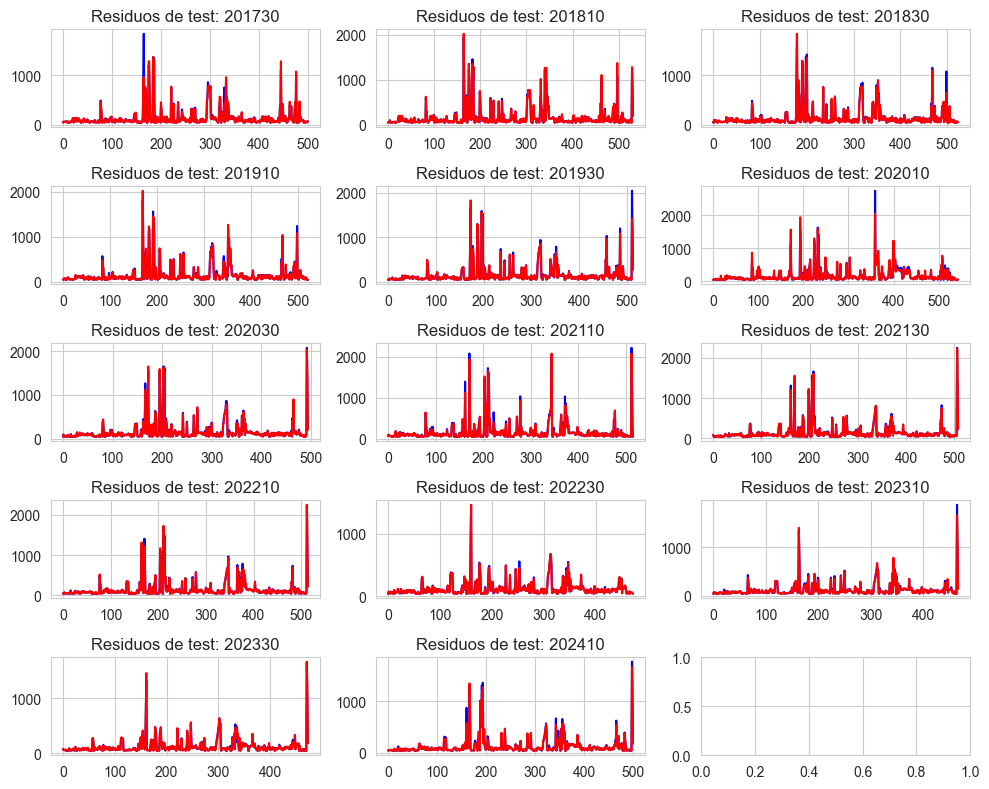

In [35]:
fig, axs = plt.subplots(5, 3, figsize=(10, 8))
for index in range(len(list_years)):
    row = index // 3
    col = index % 3
    residuos = df['reales'].iloc[index]
    predicciones = df['predicciones'].iloc[index]
    axs[row, col].plot(range(len(residuos)), residuos, color='blue')
    axs[row, col].plot(range(len(predicciones)), predicciones, color='red')
    axs[row, col].set_title(f"test vs prediccion: {list_years[index]}")
fig.tight_layout()
plt.show()

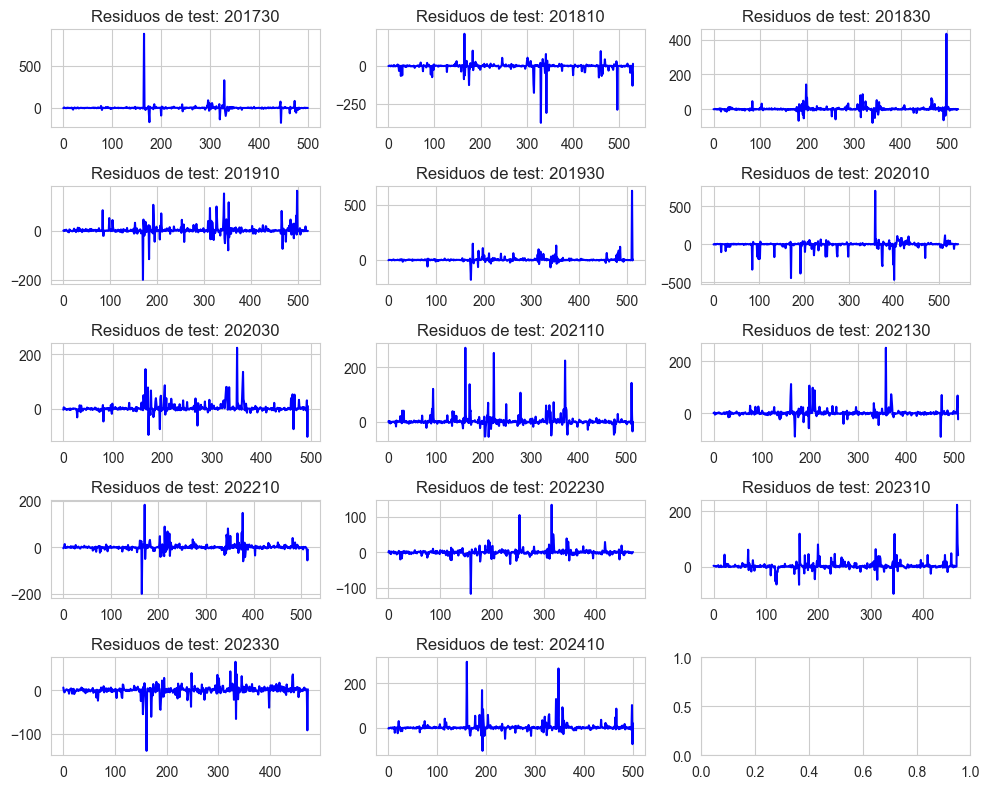

In [36]:
fig, axs = plt.subplots(5, 3, figsize=(10, 8))
for index in range(len(list_years)):
    row = index // 3
    col = index % 3
    residuos = df['residuos'].iloc[index]
    axs[row, col].plot(range(len(residuos)), residuos, color='blue')
    axs[row, col].set_title(f"Residuos de test: {list_years[index]}")
fig.tight_layout()
plt.show()


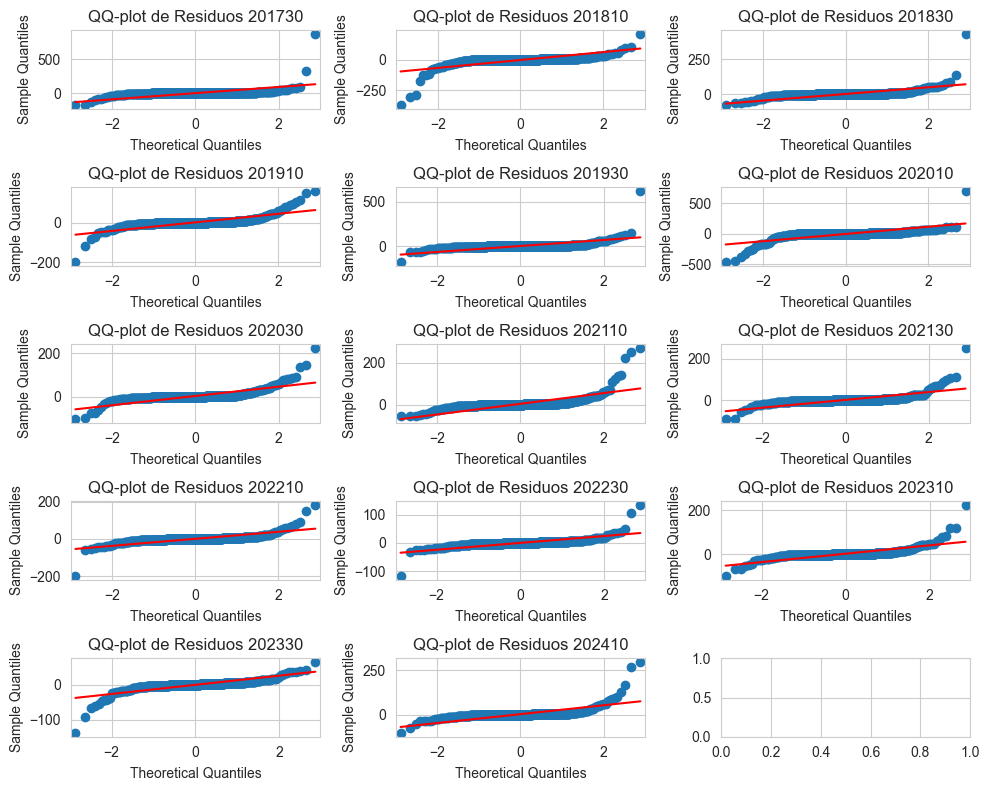

In [37]:
fig, axs = plt.subplots(5, 3, figsize=(10, 8))

for index in range(len(list_years)):
    row = index // 3
    col = index % 3

    residuos = pd.Series(df['residuos'].iloc[index])  
    sm.qqplot(residuos, line='s', ax=axs[row, col])
    axs[row, col].set_title(f'QQ-plot de Residuos {list_years[index]}')

fig.tight_layout()
plt.show()

In [38]:
transpose = (df[['Años','RMSE','MAPE','R2','Ljung-Box p-value']].T)
transpose.columns = transpose.iloc[0]
transpose =  transpose.iloc[1:]
display(transpose.T)

,RMSE,MAPE,R2,Ljung-Box p-value
Años,,,,
201730,45.853255,0.368221,0.945401,0.856325
201810,32.644502,-1.223415,0.976313,0.234047
201830,24.124083,0.529934,0.985661,0.841204
201910,21.781068,0.702044,0.989035,0.139944
201930,33.940409,0.627818,0.976618,0.989234
202010,59.517932,-4.084449,0.929718,0.100439
202030,21.561329,1.169405,0.990547,0.040498
202110,25.883235,1.113867,0.988967,0.023839
202130,18.895639,0.583387,0.991929,0.355209
